# Comparando temperaturas con HDF5

## El dataset

El organismo NOOA de los Estados Unidos proporciona datasets de diferentes medidas climatológicas descargables desde su página:

http://www.ncdc.noaa.gov/data-access/land-based-station-data/land-based-datasets

Comenzaremos descargando datos de las series **Quality Controlled Local Climatological Data (QCLCD)**, que como su nombre indica, han sido objeto de control de calidad. 

En su página de descargas:
http://www.ncdc.noaa.gov/orders/qclcd/

Vemos que organiza los datos como un fichero comprimido por año y mes. Los ficheros comprimidos son relativamente grandes, entre 30 y 80 MB. 


## La comparación
    

Vamos a comparar los datos del mes de junio de varios años.
Cada mes cuenta con los siguientes ficheros (entre otros que no tratamos aquí):
* *AAAAMMdaily.txt* : Los datos por cada día y estación
* *AAAAMMhourly.txt* : Los datos por cada día, hora y estación.
* *AAAAMMmonthly.txt* : Los datos del mes por estación.

Donde *AAAMM* es año y mes.

Lógicamente, el tamaño para mayores niveles de detalle crece de manera acorde, el nivel horario son varios cientos de MB por ejemplo.


## Pasando los datos a HDF5

Dado que un fichero HDF5 puede contener una estructura de carpetas arbitraria, utilizamos un solo fichero para guardar todos los datos. Podemos replicar la estructura de NOOA para poder actualizarlo de acuerdo a sus mismas convenciones.

In [1]:
import os
import tables as tb
import numpy as np
import pandas as pd
try:
    os.remove("nooa.h5")
except OSError:
    pass
    
f = tb.open_file("nooa.h5", "w", title="NOOA QCLCD data")
# Tomamos como ejemplo solo datos de unos meses concretos:
f.create_group("/", "qclcd201606", "Datos NOOA QCLCD June 2016")
f.create_group("/", "qclcd201006", "Datos NOOA QCLCD June 2010")
f.create_group("/", "qclcd201106", "Datos NOOA QCLCD June 2011")
f.create_group("/", "qclcd201206", "Datos NOOA QCLCD June 2012")
f.create_group("/", "qclcd200906", "Datos NOOA QCLCD June 2009")
f.create_group("/", "qclcd200706", "Datos NOOA QCLCD June 2007")

# etc.
print f
f.close()

nooa.h5 (File) 'NOOA QCLCD data'
Last modif.: 'Tue Nov  8 14:57:28 2016'
Object Tree: 
/ (RootGroup) 'NOOA QCLCD data'
/qclcd200706 (Group) 'Datos NOOA QCLCD June 2007'
/qclcd200906 (Group) 'Datos NOOA QCLCD June 2009'
/qclcd201006 (Group) 'Datos NOOA QCLCD June 2010'
/qclcd201106 (Group) 'Datos NOOA QCLCD June 2011'
/qclcd201206 (Group) 'Datos NOOA QCLCD June 2012'
/qclcd201606 (Group) 'Datos NOOA QCLCD June 2016'



La lectura de los ficheros se puede hacer por bloques, utilizando el parámetro <code>chunksize</code> de <code>read_csv</code>. Esto hace que el fichero se lea en fragmentos del número de filas especificado. Este parámetro puede perfilarse para mejorar la eficiencia de la lectura si se necesitase.

Podemos comprobar que se lee correctamente pidiendo solo las primeras lineas. 

In [2]:
pd.read_csv('./QCLCD201206/201206monthly.txt', nrows=5)

,WBAN,YearMonth,AvgMaxTemp,DepartureMaxTemp,AvgMinTemp,DepartureMinTemp,AvgTemp,DeparturefromNormal,AvgDewPoint,AvgWetBulb,...,HeavyFogDays,DaysWithPrecip>=.01inch,DaysWithPrecip>=.10inch,DaysWithSnowfall>=1.0inch,WaterEquivalent,ResultantWindSpeed,ResultantWindDirection,AvgWindSpeed,AvgHDD,AvgCDD
0,3013,201206,98.0,M,61.3,M,79.7,M,45.2,60.2,...,0,4,3,M,M,6.8,17,13.3,0.0,14.9
1,3016,201206,M,M,M,M,M,M,26.4,49.7,...,0,M,M,M,M,3.3,25,7.7,0.3,7.0
2,3017,201206,91.7,9.3,58.0,5.7,74.9,7.5,35.8,54.3,...,0,2,2,0,M,4.9,17,12.2,M,M
3,3024,201206,95.1,M,68.7,M,81.9,M,52.9,64.2,...,0,5,4,M,M,7.4,17,11.6,0.0,17.2
4,3026,201206,92.2,M,59.1,M,75.7,M,47.3,59.4,...,0,6,3,M,M,7.6,17,14.3,0.0,11.0


In [3]:
store = pd.HDFStore('nooa.h5',mode='w')
lines = 500

%time for chunk in pd.read_csv('./QCLCD201206/201206monthly.txt',chunksize=lines): store.append('qclcd201206/monthly',chunk)

CPU times: user 67 ms, sys: 5.51 ms, total: 72.5 ms
Wall time: 72.1 ms


El problema está en que al hacer la carga de datos, en muchos campos no se ha hecho la conversión que desearíamos. 

In [4]:
store.select("qclcd201206/monthly").dtypes.head(7)

WBAN                 int64
YearMonth            int64
AvgMaxTemp          object
DepartureMaxTemp    object
AvgMinTemp          object
DepartureMinTemp    object
AvgTemp             object
dtype: object

Esto es debido a que en muchos campos se utilizan letras para indicar valores especiales. Por ejemplo, en las temperaturas se utiliza "M" (missing data) como valor nulo. Por ello en la lectura es conveniente tener en cuenta estas convenciones. La hacemos de nuevo.

In [5]:
store.close()
os.remove("nooa.h5")
store = pd.HDFStore('nooa.h5',mode='w')

# Creamos una función de conversion ad hoc:
def str2f(x):
    if x=='M' or x.strip()=='T':
       return float("nan")
    else:
        return float(x)

# Tomamos solamente dos años para la comparación:
for chunk in pd.read_csv('./QCLCD200706/200706monthly.txt', chunksize=lines, \
                         converters={'AvgTemp':str2f, 'TotalMonthlyPrecip':str2f, 'AvgMaxTemp':str2f}): 
    store.append('qclcd200706/monthly',chunk, data_columns =["AvgTemp"])
    
for chunk in pd.read_csv('./QCLCD201206/201206monthly.txt', chunksize=lines, \
                         converters={'AvgTemp':str2f, 'TotalMonthlyPrecip':str2f, 'AvgMaxTemp':str2f}): 
    store.append('qclcd201206/monthly',chunk, data_columns =["AvgTemp"])



In [6]:
store.select("qclcd201206/monthly").dtypes.head(7)

WBAN                  int64
YearMonth             int64
AvgMaxTemp          float64
DepartureMaxTemp     object
AvgMinTemp           object
DepartureMinTemp     object
AvgTemp             float64
dtype: object

In [7]:
media = store.select("qclcd201206/monthly")["AvgTemp"].mean()
(media-32)/1.8

21.86527276373844

In [8]:
media = store.select("qclcd200706/monthly")["AvgTemp"].mean()
(media-32)/1.8

21.78940002433977

## Consultas con PyTables

HDFStore utiliza internamente PyTables pero nos permite manipular HDF5 como si tuviésemos arrays o dataframes.

Podemos relacionar entonces campos diversos en el dataset, por ejemplo, las precipitaciones detectadas para el mes y la temperatura media para cada estación.

/Users/msicilia/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


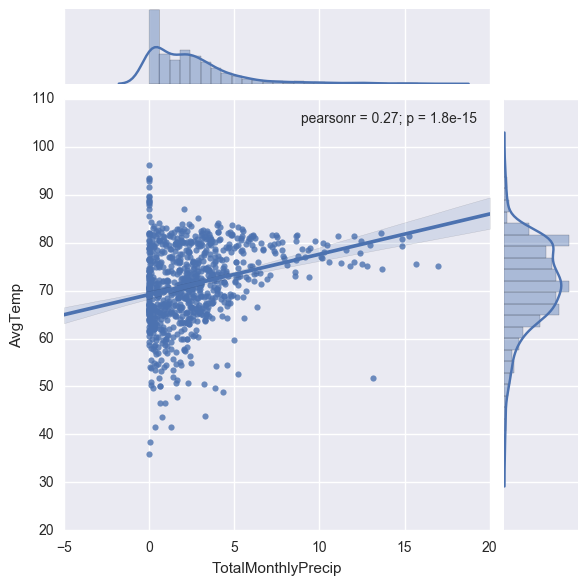

In [9]:
%matplotlib inline
import seaborn as sns
datos = store.select("qclcd200706/monthly")
cols = ["AvgTemp", "TotalMonthlyPrecip"]
sns.jointplot("TotalMonthlyPrecip", "AvgTemp", data=datos[cols].dropna(), kind="reg")

En el gráfico podemos observar que en muchas de las estaciones las precipitaciones del mes son cero o cercanas a cero, con una distribución sesgada positivamente. Curiosamente, observamos que en ese mes hay una correlación positiva entre la temperatura y las precipitaciones.

También podemos fusionar datos separados y hacer cálculos sobre los resultados. Por ejemplo, obtener las medias por estación.

In [10]:
datos2 = store.select("qclcd201206/monthly")
totales = datos.append(datos2).groupby("WBAN")
totales["AvgTemp"].mean().dropna().head(10)

WBAN
3013    75.95
3016    69.50
3017    71.85
3024    78.00
3026    73.10
3027    68.80
3028    73.25
3029    65.80
3030    76.30
3031    78.00
Name: AvgTemp, dtype: float64

También podemos fusionar los datos por estación, de manera que tenemos dos columnas por cada estación y podemos compararlas.

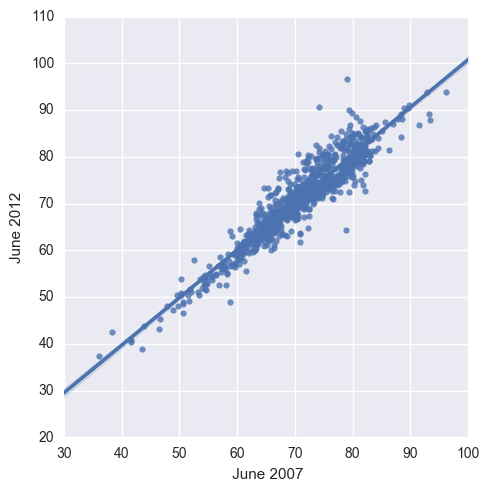

In [11]:
totales = datos.merge(datos2, how="inner", on="WBAN")
totales.head()
ax = sns.lmplot("AvgTemp_x","AvgTemp_y", data=totales)
ax.set(xlabel=' June 2007', ylabel='June 2012')

La mayoría de los puntos están cerca de la diagonal, pero vemos que en algunos casos hay alguna diferencia apreciable. Este tipo de análisis podría servir para detectar posibles problemas puntuales en las estaciones si se hace longitudinalmente en todos los años, comparando las lecturas del mismo mes para una sola estación.

## Consumo de memoria y out-of-core processing

Podemos consultar el consumo de memoria con <code>memory_usage</code>, que nos indica el consumo en un dataframe por cada columna. Al sumarlas tenemos el consumo total. 

In [12]:
datos.memory_usage().sum()

385968

In [13]:
datos[cols].memory_usage().sum()

22704

Si tuviésemos unos ficheros muy grandes, al hacer el <code>select</code> sobre el fichero HDF5 o indexarlo para obtener el DataFrame (o una selección total del dataframe con PyTables), se cargará entero en memoria, y puede ser muy lento o simplemente resultar en un <code>MemoryError</code> de Python.

Una forma "manual" de evitar esto es procesar mediante fragementos o <code>chunks</code>. De esta forma, se leen fragmentos de la tabla en el fichero HDF5, y podemos controlar el consumo de memoria. El problema es que tenemos entonces que ajustar nuestros cálculos a esta forma "incremental" de calcular. Esto se puede hacer procesando por "trozos", o si es aplicable, enviando una consulta PyTables con <code>select</code> (http://pandas.pydata.org/pandas-docs/stable/generated/pandas.HDFStore.select.html) que devuelva un conjunto de datos más reducido que entre en memoria.

In [14]:
suma = 0
rows = 0
numlines = 200
for datafragment in store.select("qclcd200706/monthly", chunksize=200):
    print datafragment.memory_usage().sum()
    rows += len(datafragment.index)
    suma += datafragment["AvgTemp"].sum()
print suma / rows

81600
81600
81600
81600
59568
68.7364693446


Para utilizar consultas PyTables es necesario que se hayan declarado al añadir los datos la columnas sobre las que se harán consultas con el parámetro <code>data_columns</code>. Si en lugar de una lista de columnas especificamos en ese parámetro el valor True, se hace que todas las columnas puedan utilizarse en consultas.

In [15]:
datos_reducidos = store.select("qclcd200706/monthly", where=["AvgTemp>70"])
datos_reducidos.memory_usage().sum()

217056

In [16]:
store.close()